In [168]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
import pickle
import seaborn as sns
import json
from imblearn.over_sampling import SMOTE
import plotly.express as px


# I - Préparation des Données 

In [231]:
#Extraction des données d’intérêt 
file_arbre = 'Data_Arbre.csv'
arbre = pd.read_csv(file_arbre)

#les colonnes pertinentes
colonnes_pertinentes = ["longitude", "latitude","haut_tot", "haut_tronc", "tronc_diam", "fk_arb_etat", "age_estim"]
data_arbre = arbre[colonnes_pertinentes].copy() #copie
print("\nDonnées avant transformation:")
print(data_arbre.head())  # 5 premiers elements
#data_arbre.describe()

# Transformation de 'fk_arb_etat' en variable binaire
data_arbre['fk_arb_etat'] = (data_arbre['fk_arb_etat'] == 'Essouché').astype(int)
print("\nDonnées après transformation:")
print(data_arbre.head())

with open('encodage', 'wb') as f:
    pickle.dump(data_arbre, f)



Données avant transformation:
   longitude   latitude  haut_tot  haut_tronc  tronc_diam fk_arb_etat  \
0   3.293264  49.840500       6.0         2.0        37.0    EN PLACE   
1   3.273380  49.861409      13.0         1.0       160.0    EN PLACE   
2   3.289068  49.844513      12.0         3.0       116.0    REMPLACÉ   
3   3.302387  49.861778      16.0         3.0       150.0    EN PLACE   
4   3.304047  49.858446       5.0         2.0       170.0    Essouché   

   age_estim  
0       15.0  
1       50.0  
2       30.0  
3       50.0  
4       40.0  

Données après transformation:
   longitude   latitude  haut_tot  haut_tronc  tronc_diam  fk_arb_etat  \
0   3.293264  49.840500       6.0         2.0        37.0            0   
1   3.273380  49.861409      13.0         1.0       160.0            0   
2   3.289068  49.844513      12.0         3.0       116.0            0   
3   3.302387  49.861778      16.0         3.0       150.0            0   
4   3.304047  49.858446       5.0      

In [232]:
# Séparation des features et de la cible
x = data_arbre.drop(columns=['fk_arb_etat'])  # Features
y = data_arbre['fk_arb_etat']  # Target

latitude_original = x['latitude']
longitude_original = x['longitude']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x) # normaliser les features

# convertir x_scaled en DataFrame 
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)

# Afficher les caractéristiques normalisées
print("\nCaractéristiques normalisées:")
print(x_scaled_df.head())

print("\nCible:")
print(y.head())

with open('normalisation', 'wb') as file:
    pickle.dump(scaler, file)



Caractéristiques normalisées:
   longitude  latitude  haut_tot  haut_tronc  tronc_diam  age_estim
0  -0.121047 -1.027327 -0.920963    -0.46555   -1.148795  -0.968413
1  -1.427386  0.976923  0.213100    -1.02441    0.934743   0.822235
2  -0.396705 -0.642658  0.051091     0.09331    0.189412  -0.200993
3   0.478338  1.012295  0.699128     0.09331    0.765349   0.822235
4   0.587422  0.692942 -1.082973    -0.46555    1.104136   0.310621

Cible:
0    0
1    0
2    0
3    0
4    1
Name: fk_arb_etat, dtype: int64


# II - Apprentissage Supervisé pour la régression classification

In [233]:
# séparation en ensembles d'entraînement (60%), de validation (25%) et de test (15%)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.15, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=42)

# Mise à l'échelle des caractéristiques (variables explicatives)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)  # entraînement et transformation sur l'ensemble d'entraînement
x_val_scaled = scaler.transform(x_val)  # transformation sur l'ensemble de validation
x_test_scaled = scaler.transform(x_test)  # transformation sur l'ensemble de test

# Concaténation de x_test_scaled avec y_test
test_data = pd.concat([pd.DataFrame(x_test_scaled, columns=x.columns), pd.DataFrame(y_test.values, columns=['target'])], axis=1)
test_data['latitude_original'] = latitude_original
test_data['longitude_original'] = longitude_original

json_file = test_data.to_json('test_data.json', orient='records') # sauvegarde des données de test au format JSON
print(test_data.head())

nombre_arbres = test_data['target'].sum()
print("Nombre d'arbres essouchés ", nombre_arbres)
#nombre_arbres_essouches = test_data['cible'].sum()
#print(f"Nombre d'arbres essouchés : {nombre_arbres_essouches}")



   longitude  latitude  haut_tot  haut_tronc  tronc_diam  age_estim  target  \
0   0.422905  1.367051  1.001937     1.20207    0.108097   0.046213       0   
1  -1.481873 -0.351277 -0.610010    -0.47418   -0.350711  -0.730176       0   
2   0.969598  0.354073  0.518353    -1.03293    0.923755   0.305009       0   
3  -0.306079  0.745533 -0.448816    -0.47418    0.668862   0.201491       0   
4   0.250887 -1.622275  0.518353     0.08457    0.159075   0.305009       0   

   latitude_original  longitude_original  
0          49.840500            3.293264  
1          49.861409            3.273380  
2          49.844513            3.289068  
3          49.861778            3.302387  
4          49.858446            3.304047  
Nombre d'arbres essouchés  18


## Stochastic Gradient Descent

In [186]:
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train_scaled, y_train)  # entraînement du modèle sur les données d'entraînement mises à l'échelle

# prédiction 
y_pred = sgd_clf.predict(x_val_scaled)

# Calcul de la matrice de confusion sur l'ensemble de test
matrix = confusion_matrix(y_val, y_pred)  # Utilisation de y_val et y_pred pour la matrice de confusion

# Calcul des métriques d'évaluation

# Validation croisée pour évaluer la performance du modèle
scores = cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", matrix)
print(classification_report(y_val, y_pred))

# plot_roc_curve(sgd_clf, x_test_scaled, y_test)
# plt.show()
# plot_roc(y_test, y_pred)
# plt.show()


Scores de précision pour chaque fold : [0.97712834 0.97712834 0.97649301]
Précision moyenne : 0.9769165607793308
Matrice de confusion :
 [[1537    0]
 [  38    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1537
           1       0.00      0.00      0.00        38

    accuracy                           0.98      1575
   macro avg       0.49      0.50      0.49      1575
weighted avg       0.95      0.98      0.96      1575



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [174]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train_res, y_train_res) # l'ensemble d'entraînement seulement

y_pred = sgd_clf.predict(x_test_scaled) # prédiction sur l'ensemble de test
scores = cross_val_score(sgd_clf, x_train_res, y_train_res, cv=3, scoring='accuracy')

# affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))


Scores de précision pour chaque fold : [0.60598179 0.6195122  0.56617886]
Précision moyenne : 0.5972242838163102
Matrice de confusion :
 [[846 248]
 [ 15   3]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.77      0.87      1094
           1       0.01      0.17      0.02        18

    accuracy                           0.76      1112
   macro avg       0.50      0.47      0.44      1112
weighted avg       0.97      0.76      0.85      1112



## Gradient Boosting Machines

In [187]:
gb_clf = GradientBoostingClassifier()

# Entraînement du modèle sur les données d'entraînement
gb_clf.fit(x_train, y_train)

# Prédiction sur l'ensemble de validation
y_pred = gb_clf.predict(x_val)

# Calcul de la matrice de confusion sur l'ensemble de validation
matrix = confusion_matrix(y_val, y_pred)

# Validation croisée pour évaluer la performance du modèle
scores = cross_val_score(gb_clf, x_train, y_train, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", matrix)
print(classification_report(y_val, y_pred))



Scores de précision pour chaque fold : [0.97522236 0.97395172 0.97141042]
Précision moyenne : 0.9735281660313427
Matrice de confusion :
 [[1531    6]
 [  38    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1537
           1       0.00      0.00      0.00        38

    accuracy                           0.97      1575
   macro avg       0.49      0.50      0.49      1575
weighted avg       0.95      0.97      0.96      1575



In [176]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

sgd_clf = GradientBoostingClassifier(random_state=42)
sgd_clf.fit(x_train_res, y_train_res) # l'ensemble d'entraînement seulement

y_pred = sgd_clf.predict(x_test_scaled) # prédiction sur l'ensemble de test
scores = cross_val_score(sgd_clf, x_train_res, y_train_res, cv=3, scoring='accuracy')

# affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))

Scores de précision pour chaque fold : [0.92295189 0.9196748  0.91772358]
Précision moyenne : 0.9201167531831365
Matrice de confusion :
 [[1009   85]
 [  11    7]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.92      0.95      1094
           1       0.08      0.39      0.13        18

    accuracy                           0.91      1112
   macro avg       0.53      0.66      0.54      1112
weighted avg       0.97      0.91      0.94      1112



## Support Vector Machines

In [199]:
svc_clf = SVC()

# Entraînement du modèle sur les données d'entraînement
svc_clf.fit(x_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = svc_clf.predict(x_test)

# Calcul de la matrice de confusion sur l'ensemble de test
matrix = confusion_matrix(y_test, y_pred)

# Validation croisée pour évaluer la performance du modèle
scores = cross_val_score(svc_clf, x_scaled, y, cv=3, scoring='accuracy')

# Affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", matrix)
print(classification_report(y_test, y_pred))


Scores de précision pour chaque fold : [0.97773279 0.97773279 0.97772377]
Précision moyenne : 0.9777297872840496
Matrice de confusion :
 [[1094    0]
 [  18    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1094
           1       0.00      0.00      0.00        18

    accuracy                           0.98      1112
   macro avg       0.49      0.50      0.50      1112
weighted avg       0.97      0.98      0.98      1112



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [178]:
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train)

sgd_clf = SVC(random_state=42)
sgd_clf.fit(x_train_res, y_train_res) # l'ensemble d'entraînement seulement

y_pred = sgd_clf.predict(x_test_scaled) # prédiction sur l'ensemble de test
scores = cross_val_score(sgd_clf, x_train_res, y_train_res, cv=3, scoring='accuracy')

# affichage des résultats
print("Scores de précision pour chaque fold :", scores)
print("Précision moyenne :", scores.mean())
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de classification :\n", classification_report(y_test, y_pred))



Scores de précision pour chaque fold : [0.8026658  0.80585366 0.78276423]
Précision moyenne : 0.7970945619729278
Matrice de confusion :
 [[792 302]
 [  7  11]]

Rapport de classification :
               precision    recall  f1-score   support

           0       0.99      0.72      0.84      1094
           1       0.04      0.61      0.07        18

    accuracy                           0.72      1112
   macro avg       0.51      0.67      0.45      1112
weighted avg       0.98      0.72      0.82      1112



# III - GridSearchCV

## Stochastic Gradient Descent  

In [200]:
#Stochastic Gradient Descent  

param_grid_sgd = {
    'loss': ['hinge', 'modified_huber', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}


grid_search = GridSearchCV(SGDClassifier(), param_grid_sgd, cv=3, scoring='accuracy', verbose=2, error_score='raise')
grid_search.fit(x_train, y_train) #entrainement 

print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)
print("Meilleur score de validation croisée :")
print(grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_sgd = best_model.predict(x_test)

print("Rapport de classification sur l'ensemble de test :")
print(classification_report(y_test, y_pred_sgd))

# Enregistrement du meilleur modèle
with open('best_sgd_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
    print("Enregistrement du modèle Stochastic Gradient Descent ")




Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=1000, penalty=elasticnet; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, loss=hinge, max_iter=2000, penalty=l2; total time=   0.0s
[CV] END alpha=0.0001, 

## Gradient Boosting Machines


In [180]:
#Gradient Boosting Machines

param_grid_gbc = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.001],
    'min_samples_split': [2, 3, 1],
    'min_samples_leaf': [1, 2]

}
grid_search_gbc = GridSearchCV(GradientBoostingClassifier(), param_grid_gbc, cv=3, scoring='accuracy', verbose=2)

grid_search_gbc.fit(x_train, y_train) #entrainement 
print("Meilleurs paramètres trouvés :")
print(grid_search_gbc.best_params_)

print("Meilleur score de validation croisée :")
print(grid_search_gbc.best_score_)

best_model_gbc = grid_search_gbc.best_estimator_
y_pred_gbc = best_model_gbc.predict(x_test)
print("Rapport de classification sur l'ensemble de test :")
print(classification_report(y_test, y_pred_gbc))

# Enregistrement du meilleur modèle
with open('best_gbm_model.pkl', 'wb') as file:
    pickle.dump(best_model_gbc, file)
    print("Enregistrement du modèle Gradient Boosting Machines ")



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Meilleurs paramètres trouvés :
{'learning_rate': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Meilleur score de validation croisée :
0.9771283354510801
Rapport de classification sur l'ensemble de test :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1094
           1       0.40      0.11      0.17        18

    accuracy                           0.98      1112
   macro avg       0.69      0.55      0.58      1112
weighted avg       0.98      0.98      0.98      1112

Enregistrement du modèle Gradient Boosting Machines 


## Support Vector Machines


In [181]:

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'], 
    'degree': [3, 2, 1]

}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='accuracy', verbose=2)

grid_search_svm.fit(x_train, y_train) #entrainement 
print("Meilleurs paramètres trouvés :")
print(grid_search_svm.best_params_)

print("Meilleur score de validation croisée :")
print(grid_search_svm.best_score_)

best_model_svm = grid_search_svm.best_estimator_
y_pred_svm = best_model_svm.predict(x_test)
classe = classification_report(y_test, y_pred)

print("Rapport de classification sur l'ensemble de test :", classe)
#print(classification_report(y_test, y_pred_svm))

# Enregistrement du meilleur modèle
with open('best_svm_model.pkl', 'wb') as file:
    pickle.dump(best_model_svm, file)
    print("Enregistrement du modèle Gradient Boosting Machines ")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END .......................C=0.1, degree=3, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=3, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=3, gamma=scale; total time=   0.0s
[CV] END ........................C=0.1, degree=3, gamma=auto; total time=   0.2s
[CV] END ........................C=0.1, degree=3, gamma=auto; total time=   0.2s
[CV] END ........................C=0.1, degree=3, gamma=auto; total time=   0.2s
[CV] END .......................C=0.1, degree=2, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=2, gamma=scale; total time=   0.0s
[CV] END .......................C=0.1, degree=2, gamma=scale; total time=   0.0s
[CV] END ........................C=0.1, degree=2, gamma=auto; total time=   0.2s
[CV] END ........................C=0.1, degree=2, gamma=auto; total time=   0.2s
[CV] END ........................C=0.1, degree=2

# IV - Préparation du Script 

In [ ]:
# III - Préparation du Script
# Charger le modèle sauvegardé
model_file = 'best_sgd_model.pkl'
with open(model_file, 'rb') as file:
    best_sgd_model = pickle.load(file)

# Faire des prédictions sur l'ensemble de test
predictions_sgd = best_sgd_model.predict(x_scaled)

# Ajouter les prédictions au dataframe
x_scaled_df = pd.DataFrame(x_scaled, columns=x.columns)
x_scaled_df['scaled_prediction'] = predictions_sgd

# Combiner les caractéristiques mises à l'échelle avec la latitude et la longitude d'origine pour le traçage
plot_data_sgd = pd.concat([x[['longitude', 'latitude']], x_scaled_df['scaled_prediction']], axis=1)

# Afficher la carte avec les prédictions
plt.figure(figsize=(10, 8))
sc = plt.scatter(plot_data_sgd['longitude'], plot_data_sgd['latitude'], c=plot_data_sgd['scaled_prediction'], cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='Risque de déracinement (scaled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Carte des arbres en risque de déracinement')
plt.grid(True)
plt.show()


In [213]:
# Charger le modèle sauvegardé
model_file = 'best_sgd_model.pkl'
with open(model_file, 'rb') as file:
    best_model = pickle.load(file)

# Charger les données de test à partir du fichier JSON
data_json_file = 'test_data.json'
with open(data_json_file, 'r') as file:
    data_json = json.load(file)

# Convertir les données JSON en DataFrame
test_data_map = pd.DataFrame(data_json)

# Assurer que les colonnes sont dans le même ordre que pendant l'entraînement
variables = best_model.feature_names_in_
print("Variables du modèle :", variables)

for i in variables:  # ajouter les colonnes manquantes avec des valeurs par défaut
    if i not in test_data_map.columns:
        test_data_map[i] = 0  # ou une autre valeur par défaut appropriée

# Remettre les colonnes à celles du modèle
test_data_map = test_data_map[variables]

# Faire des prédictions sur l'ensemble de test
predictions = best_model.predict(test_data_map)

# Ajouter les prédictions au dataframe
test_data_map['prediction'] = predictions

# Afficher la carte avec les prédictions
fig = px.scatter_mapbox(
    test_data_map,
    lat='latitude',
    lon='longitude',
    color='prediction',
    title='Carte des arbres en risque de déracinement à Saint-Quentin'
)

fig.update_layout(
    mapbox=dict(
        center=dict(lat=49.8489, lon=3.2876),
        zoom=13
    ),
    mapbox_style='open-street-map',
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()

Variables du modèle : ['longitude' 'latitude' 'haut_tot' 'haut_tronc' 'tronc_diam' 'age_estim']


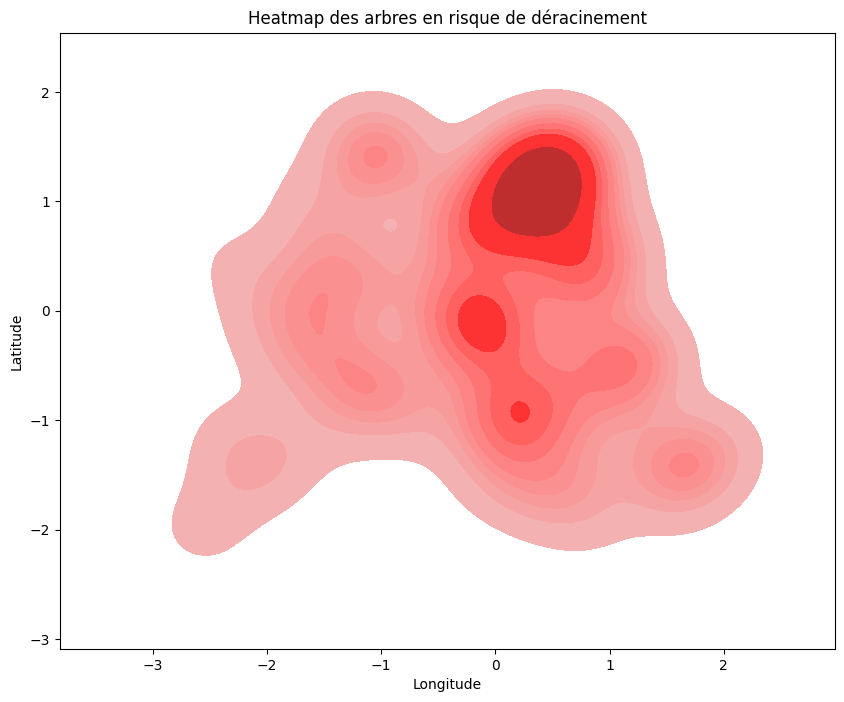

In [184]:
plt.figure(figsize=(10, 8))
sns.kdeplot(data=test_data_map, x='longitude', y='latitude', fill=True, color='red')
plt.title('Heatmap des arbres en risque de déracinement')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


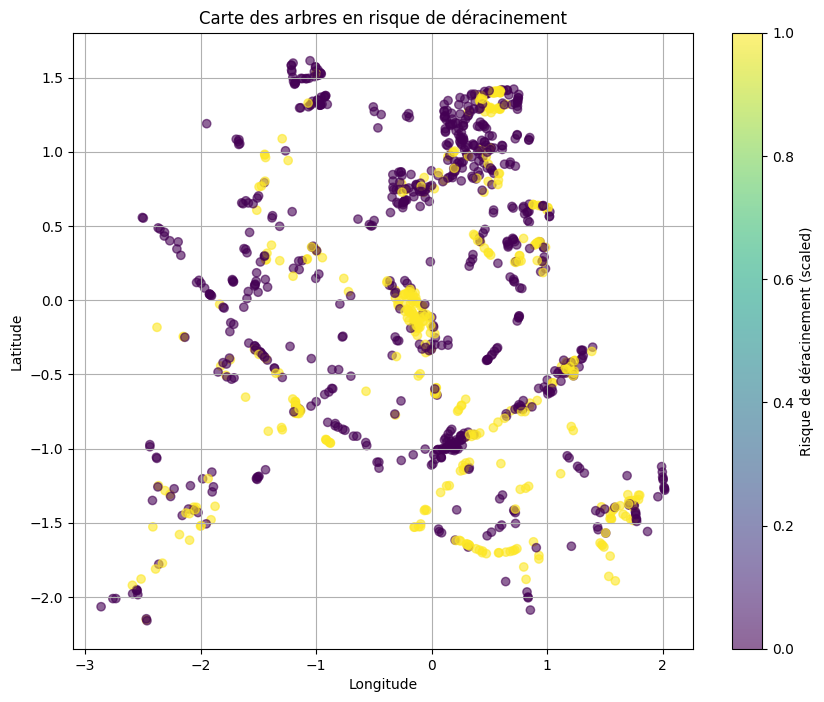

In [229]:
model_file = 'best_sgd_model.pkl'
with open(model_file, 'rb') as file:
    best_sgd_model = pickle.load(file)
data_json_file = 'test_data.json'
with open(data_json_file, 'r') as file:
    data_json = json.load(file)

# les données JSON en DataFrame
data_map = pd.DataFrame(data_json)

# assurer que les colonnes sont dans le même ordre que pendant l'entraînement
data_map = data_map[x.columns]
predictions_sgd = best_sgd_model.predict(data_map)
result_df = pd.DataFrame({'longitude': data_map['longitude'], 'latitude': data_map['latitude'], 'prediction': predictions_sgd })

# 3. Plot the results
plt.figure(figsize=(10, 8))
sc = plt.scatter(result_df['longitude'], result_df['latitude'], c=result_df['prediction'], alpha=0.6)
plt.colorbar(sc, label='Risque de déracinement (scaled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Carte des arbres en risque de déracinement')
plt.grid(True)
plt.show()